In [17]:
!pip install numpy pandas matplotlib seaborn librosa scikit-learn tqdm soundfile

  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)


In [2]:
import tarfile
import os

data_path = r"F:\Firefox downloader\Projects\Project 2 - Music Genre Indentification"
tar_file = os.path.join(data_path, "genres.tar.gz")

with tarfile.open(tar_file, 'r:gz') as tar:
    tar.extractall(path=data_path)

In [3]:
import os

genres_dir = r"F:\Firefox downloader\Projects\Project 2 - Music Genre Indentification\genres"
genres = [d for d in os.listdir(genres_dir) if os.path.isdir(os.path.join(genres_dir, d))]
print("Genres:", genres)

for genre in genres:
    files = os.listdir(os.path.join(genres_dir, genre))
    print(f"{genre}: {len(files)} files")

Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
blues: 100 files
classical: 100 files
country: 100 files
disco: 100 files
hiphop: 100 files
jazz: 100 files
metal: 100 files
pop: 100 files
reggae: 100 files
rock: 100 files


In [4]:
import glob

audio_files = []
labels = []

for genre in genres:
    genre_path = os.path.join(genres_dir, genre)
    files = glob.glob(os.path.join(genre_path, "*.au"))  # Use .au extension
    print(f"{genre}: {len(files)} .au files found")
    audio_files.extend(files)
    labels.extend([genre] * len(files))

print(f"Total audio files: {len(audio_files)}")

blues: 100 .au files found
classical: 100 .au files found
country: 100 .au files found
disco: 100 .au files found
hiphop: 100 .au files found
jazz: 100 .au files found
metal: 100 .au files found
pop: 100 .au files found
reggae: 100 .au files found
rock: 100 .au files found
Total audio files: 1000


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

audio_files = np.array(audio_files)
labels = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(
    audio_files, labels, test_size=0.2, stratify=labels, random_state=42
)

print(f"Train: {len(X_train)}, Validation: {len(X_val)}")


Train: 800, Validation: 200


In [6]:
import librosa
import numpy as np

def extract_features(file_path, n_mfcc=40, max_len=130):
    y, sr = librosa.load(file_path, sr=None, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Pad or truncate to max_len
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

In [7]:
from tqdm import tqdm

def build_feature_dataset(file_list, label_list, n_mfcc=40, max_len=130):
    X = []
    y = []
    for f, label in tqdm(zip(file_list, label_list), total=len(file_list)):
        try:
            features = extract_features(f, n_mfcc=n_mfcc, max_len=max_len)
            X.append(features)
            y.append(label)
        except Exception as e:
            print(f"Error processing {f}: {e}")
    return np.array(X), np.array(y)

X_train_feat, y_train_feat = build_feature_dataset(X_train, y_train)
X_val_feat, y_val_feat = build_feature_dataset(X_val, y_val)

print("Feature shape:", X_train_feat.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.67it/s]

Feature shape: (800, 40, 130)


In [8]:
import numpy
print(numpy.__version__)
print(numpy.__file__)


1.26.4
C:\Users\Yasi Kasmi\anaconda3\envs\tf-gpu-clean\lib\site-packages\numpy\__init__.py


In [9]:
import numpy
print(numpy.__version__)
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


1.26.4
2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_feat)
y_val_enc = le.transform(y_val_feat)

y_train_cat = to_categorical(y_train_enc, num_classes=len(genres))
y_val_cat = to_categorical(y_val_enc, num_classes=len(genres))

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train_feat.shape[1:]  # (n_mfcc, max_len)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((*input_shape, 1)),  # Add channel dimension
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(genres), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 40, 130, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 40, 130, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 65, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 65, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 20480)             0

In [13]:
history = model.fit(
    X_train_feat, y_train_cat,
    validation_data=(X_val_feat, y_val_cat),
    epochs=30,
    batch_size=32
)

Epoch 1/30
25/25 [==============================] - 10s 19ms/step - loss: 15.3107 - accuracy: 0.1013 - val_loss: 2.2447 - val_accuracy: 0.1300
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 2.1705 - accuracy: 0.2050 - val_loss: 2.0445 - val_accuracy: 0.2450
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 1.7977 - accuracy: 0.3787 - val_loss: 1.8876 - val_accuracy: 0.3500
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 1.3759 - accuracy: 0.5450 - val_loss: 1.9015 - val_accuracy: 0.3600
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 1.0571 - accuracy: 0.6338 - val_loss: 1.9439 - val_accuracy: 0.3450
Epoch 6/30
25/25 [==============================] - 0s 8ms/step - loss: 0.8309 - accuracy: 0.7113 - val_loss: 2.0647 - val_accuracy: 0.3500
Epoch 7/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6145 - accuracy: 0.8062 - val_loss: 2.1618 - val_accuracy: 0.3250
Epoch 8/30
25/25 

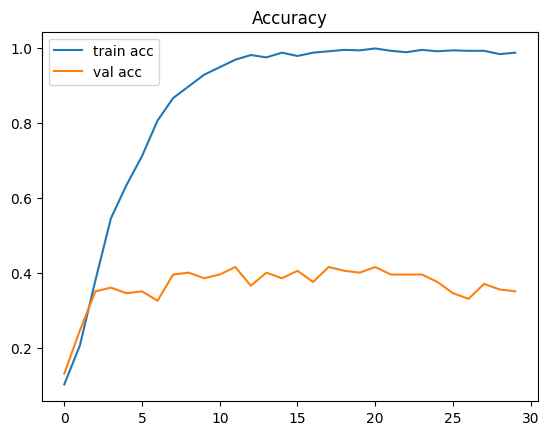

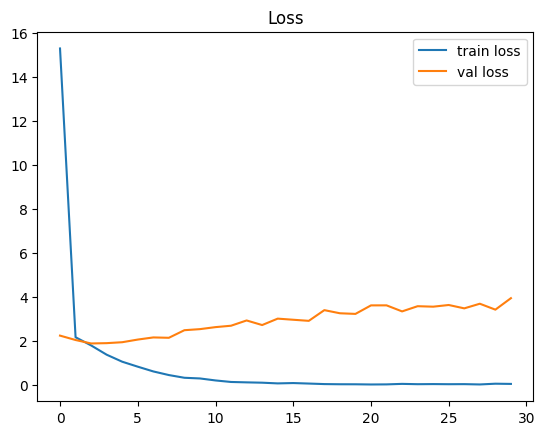

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       blues       0.08      0.10      0.09        20
   classical       0.58      0.55      0.56        20
     country       0.40      0.30      0.34        20
       disco       0.27      0.15      0.19        20
      hiphop       0.33      0.70      0.45        20
        jazz       0.59      0.50      0.54        20
       metal       0.26      0.50      0.34        20
         pop       0.56      0.50      0.53        20
      reggae       0.33      0.20      0.25        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.35       200
   macro avg       0.34      0.35      0.33       200
weighted avg       0.34      0.35      0.33       200



In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss")
plt.show()

from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_val_feat), axis=1)
print(classification_report(y_val_enc, y_pred, target_names=le.classes_))

In [15]:
model.save("genre_cnn_model.h5")
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [16]:
def predict_genre(file_path):
    features = extract_features(file_path)
    features = np.expand_dims(features, axis=0)
    pred = np.argmax(model.predict(features), axis=1)
    return le.inverse_transform(pred)[0]

# Example usage:
# print(predict_genre(r"F:\path\to\some\file.au"))